In [35]:
# --- Cabeçalho do Arquivo ---
#
# Título do Projeto: Análise da Correlação entre o Uso de Criptoativos e a Circulação Monetária no Brasil
#
# Integrante:
# Luke Marques Magalhães RA: 10401112
#
# Disciplina: Inteligência Artificial - 7ºJ SI - Noite
# Professor: Prof. Dr. Leandro Zerbinatti
# Instituição: Universidade Presbiteriana Mackenzie
#
# Síntese do Conteúdo:
# Este arquivo Jupyter Notebook contém o código Python para a análise exploratória e preparação dos dados,
# focando em limpeza, integração e visualização inicial das variáveis de criptoativos e circulação monetária.
# Com carregamento e preparação dos dados, análise exploratória (EDA),
# modelagem preditiva (Regressão Linear, MLP), avaliação dos modelos (MAE, R²)
# e visualização dos resultados.

In [36]:
# --- Importação das bibliotecas ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
import json

In [37]:
# --- Carregamento e tratamento do Excel (dados de criptoativos) ---
print("Carregando dados de criptoativos...")
df_cripto = pd.read_excel('criptoativos_dados_abertos_20250115.xls', sheet_name='Relatorio4', header=14)

# Função para converter o campo "MÊS/ANO" em formato datetime
def converter_mes_ano(data_texto):
    meses = {"janeiro": "01", "fevereiro": "02", "março": "03", "abril": "04", "maio": "05",
             "junho": "06", "julho": "07", "agosto": "08", "setembro": "09", "outubro": "10",
             "novembro": "11", "dezembro": "12"}
    partes = data_texto.lower().split(" de ")
    mes = meses.get(partes[0])
    ano = partes[1]
    return f"{ano}-{mes}-01"

df_cripto['Data'] = pd.to_datetime(df_cripto['MÊS/ANO'].apply(converter_mes_ano))
df_cripto = df_cripto[['Data', 'Nº DE OPERAÇÕES', 'VALOR TOTAL DAS OPERAÇÕES']].dropna()

Carregando dados de criptoativos...


In [38]:
# --- Carregamento e tratamento do JSON (dados de circulação monetária) ---
print("Carregando dados de circulação monetária...")
with open("Informações Diárias Detalhado.json", 'r', encoding='utf-8') as f:
    data_json = json.load(f)

try:
    df_bc = pd.json_normalize(data_json, 'value')
except KeyError:
    df_bc = pd.json_normalize(data_json)

df_bc['Data'] = pd.to_datetime(df_bc['Data'], errors='coerce')
df_bc = df_bc[['Data', 'Quantidade']].dropna()

Carregando dados de circulação monetária...


In [39]:
# --- Agregação mensal e integração dos dados ---
print("Preparando e integrando os dados...")
df_bc_mensal = df_bc.resample('MS', on='Data').sum().reset_index().rename(columns={'Quantidade': 'Circulacao_Monetaria'})
df_cripto_mensal = df_cripto.resample('MS', on='Data').sum().reset_index()
df_integrado = pd.merge(df_cripto_mensal, df_bc_mensal, on='Data', how='inner')

# Filtrar para dados até Novembro de 2024
df_integrado_filtered = df_integrado[df_integrado['Data'] <= '2024-11-30']

Preparando e integrando os dados...


Análise Exploratória dos Dados
<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       64 non-null     datetime64[ns]
 1   Nº DE OPERAÇÕES            64 non-null     int64         
 2   VALOR TOTAL DAS OPERAÇÕES  64 non-null     float64       
 3   Circulacao_Monetaria       64 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.5 KB
None
                      Data  Nº DE OPERAÇÕES  VALOR TOTAL DAS OPERAÇÕES  \
count                   64     6.400000e+01               6.400000e+01   
mean   2022-03-17 07:07:30     5.409817e+06               1.658436e+10   
min    2019-08-01 00:00:00     4.873770e+05               3.979448e+09   
25%    2020-11-23 12:00:00     2.152960e+06               1.089466e+10   
50%    2022-03-16 12:00:00     4.961572e+06       

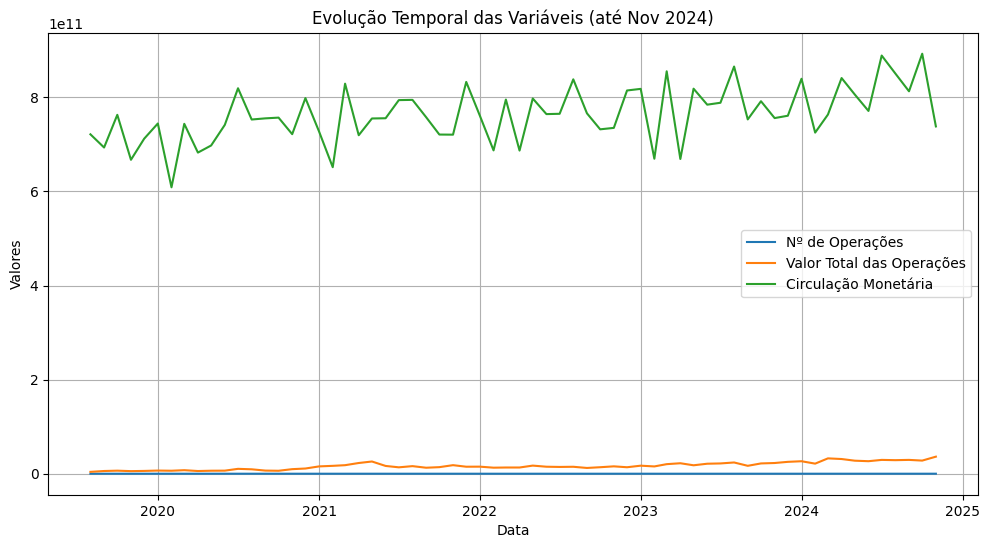

In [40]:
# --- Análise Exploratória ---
print("Análise Exploratória dos Dados")
print(df_integrado_filtered.info())
print(df_integrado_filtered.describe())

plt.figure(figsize=(12,6))
plt.plot(df_integrado_filtered['Data'], df_integrado_filtered['Nº DE OPERAÇÕES'], label='Nº de Operações')
plt.plot(df_integrado_filtered['Data'], df_integrado_filtered['VALOR TOTAL DAS OPERAÇÕES'], label='Valor Total das Operações')
plt.plot(df_integrado_filtered['Data'], df_integrado_filtered['Circulacao_Monetaria'], label='Circulação Monetária')
plt.title('Evolução Temporal das Variáveis (até Nov 2024)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

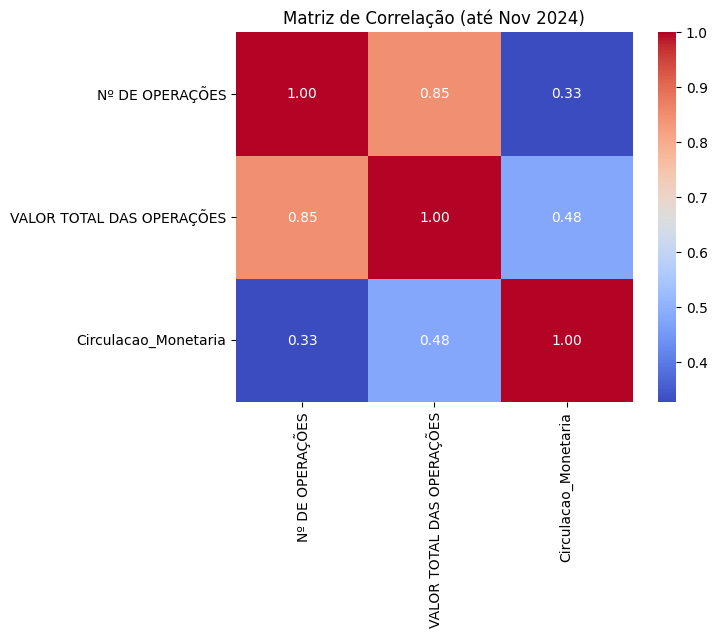

In [41]:
# Matriz de correlação
corr = df_integrado_filtered[['Nº DE OPERAÇÕES', 'VALOR TOTAL DAS OPERAÇÕES', 'Circulacao_Monetaria']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (até Nov 2024)')
plt.show()

In [42]:
# --- Modelagem Preditiva ---
print("Executando modelos preditivos...")
X = df_integrado_filtered[['Nº DE OPERAÇÕES', 'VALOR TOTAL DAS OPERAÇÕES']]
y = df_integrado_filtered['Circulacao_Monetaria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Executando modelos preditivos...


In [43]:
# Regressão Linear
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [44]:
# Rede Neural MLP
mlp = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Regressão Linear -> MAE: 42,451,393,047.21, R²: -0.16
Rede Neural MLP -> MAE: 341,201,684,024.00, R²: -48.94


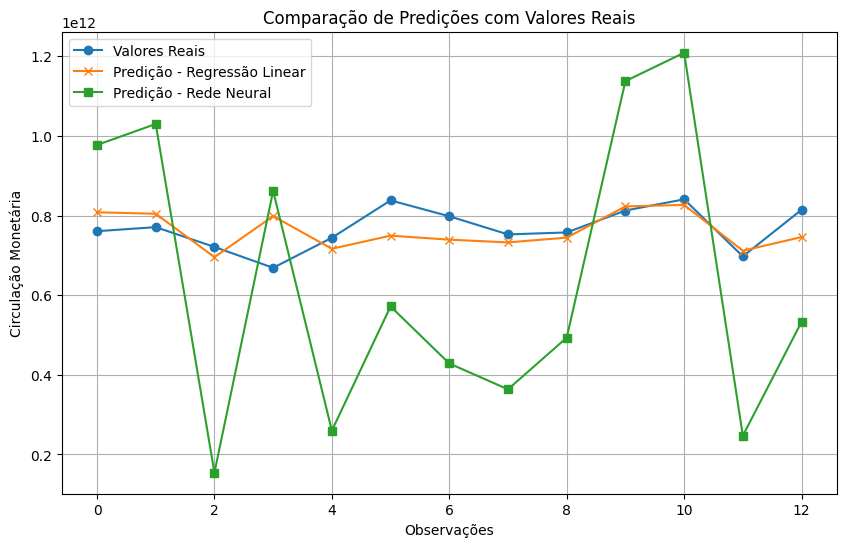

In [45]:
# Função para avaliação dos modelos
def avaliar(y_true, y_pred, nome):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{nome} -> MAE: {mae:,.2f}, R²: {r2:.2f}")

avaliar(y_test, y_pred_lr, 'Regressão Linear')
avaliar(y_test, y_pred_mlp, 'Rede Neural MLP')

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Valores Reais', marker='o')
plt.plot(y_pred_lr, label='Predição - Regressão Linear', marker='x')
plt.plot(y_pred_mlp, label='Predição - Rede Neural', marker='s')
plt.title('Comparação de Predições com Valores Reais')
plt.xlabel('Observações')
plt.ylabel('Circulação Monetária')
plt.legend()
plt.grid(True)
plt.show()

Executando KMeans para identificar clusters...


<ipython-input-46-cf40caf0bfb2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_integrado_filtered['Cluster'] = kmeans.labels_


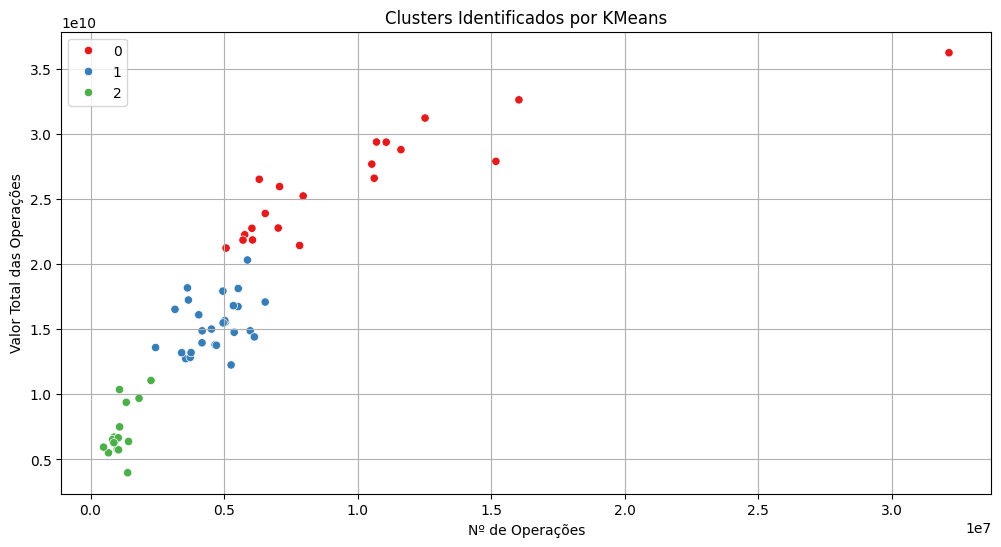

In [46]:
# --- Clusterização com KMeans ---
print("Executando KMeans para identificar clusters...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
df_integrado_filtered['Cluster'] = kmeans.labels_

plt.figure(figsize=(12,6))
sns.scatterplot(x='Nº DE OPERAÇÕES', y='VALOR TOTAL DAS OPERAÇÕES', hue='Cluster', data=df_integrado_filtered, palette='Set1')
plt.title('Clusters Identificados por KMeans')
plt.xlabel('Nº de Operações')
plt.ylabel('Valor Total das Operações')
plt.legend()
plt.grid(True)
plt.show()

Executando PCA para visualização dos clusters...


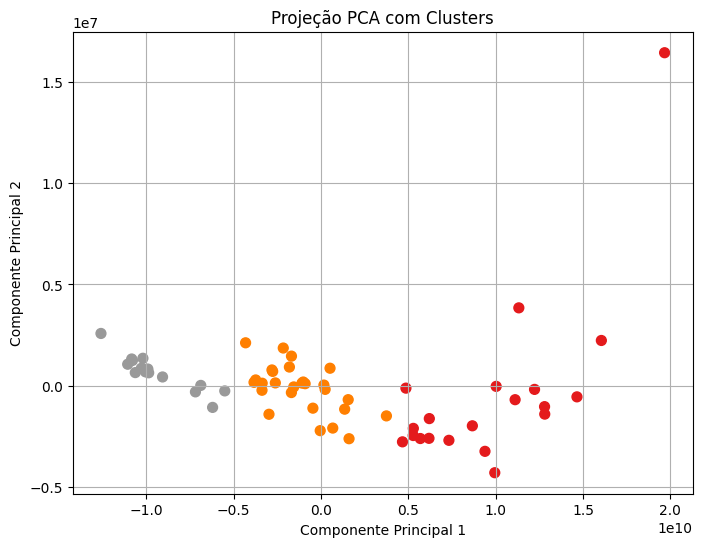

Análise concluída com sucesso!


In [47]:
# --- PCA para redução de dimensionalidade e visualização ---
print("Executando PCA para visualização dos clusters...")
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(pca_components[:,0], pca_components[:,1], c=kmeans.labels_, cmap='Set1', s=50)
plt.title('Projeção PCA com Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

print("Análise concluída com sucesso!")